## Import modules

In [2]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

## Import functions

In [3]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

## Matrix X

In [4]:
pc1_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF1pc_SW.npy')
pc2_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF2pc_SW.npy')
pc3_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF3pc_SW.npy')
pc4_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF4pc_SW.npy')
pc5_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF5pc_SW.npy')

PC_df_PPE = pd.DataFrame(pc1_PPE)
PC_df_PPE['pc1'] = pc1_PPE
PC_df_PPE['pc2'] = pc2_PPE
PC_df_PPE['pc3'] = pc3_PPE
#PC_df_PPE['pc4'] = pc4_PPE
#PC_df_PPE['pc5'] = pc5_PPE
PC_df_PPE = PC_df_PPE.drop(labels = 0, axis=1)
PC_df_PPE

,pc1,pc2,pc3
0,2.047448,-1.880354,0.695999
1,0.089597,0.496123,0.467096
2,0.116893,-1.046918,0.690331
3,0.185766,-0.481640,-1.690326
4,0.715678,-2.260945,0.754597
...,...,...,...
97,0.171422,1.157356,1.041254
98,-1.242337,0.038289,0.261865
99,-0.690952,0.455630,0.653965
100,0.174499,0.459449,1.376661


## Multi Linear Regression model 

In [5]:
# Set the X and Y : Y = f(X)
X = PC_df_PPE.values
y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

In [6]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('Score: \n', regr.score(X, y))

Intercept: 
 -1.3656722
Coefficients: 
 [ 0.09902116 -0.05805739 -0.02602605]
Score: 
 0.3493685085820508


In [7]:
Coeffs = pd.DataFrame([regr.coef_]).iloc[0]
Coeffs_sorted = Coeffs.sort_values()
Coeffs

0    0.099021
1   -0.058057
2   -0.026026
Name: 0, dtype: float64

In [8]:
# Let's write the equation : 
X_df = pd.DataFrame(data=X)
R = regr.intercept_

N=len(X_df.values)
tmp = [0]*N
y_eq = [0]*N
i=0
Ycpt=0
while i<N:
    tmp[i] = Coeffs.values*X_df.iloc[i]
    y_eq[i] = tmp[i].sum()+R
    i+=1
    
#y_eq 

In [9]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

y_true = y

DFYeq = pd.DataFrame([y_true, y_eq], index=['y_true', 'y_eq']).transpose()
DFYeq['members'] = nb_p_list
DFYeq['members_0'] = range(0,102,1)
#DF=DFYeq.sort_values(by='y_true')
DFYeq

,y_true,y_eq,members,members_0
0,-0.789073,-1.071877,p311,0
1,-1.666454,-1.397761,p312,1
2,-1.214114,-1.311283,p314,2
3,-1.292415,-1.275322,p316,3
4,-0.756525,-1.183180,p317,4
...,...,...,...,...
97,-1.496774,-1.442991,p465,97
98,-1.571997,-1.497728,p467,98
99,-1.489540,-1.477564,p469,99
100,-1.430751,-1.410897,p470,100


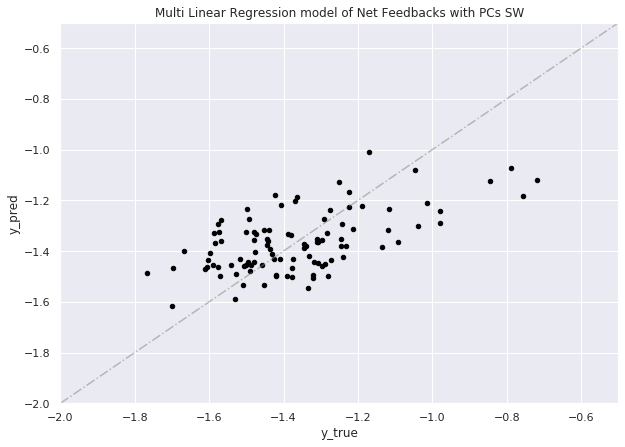

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = plt.gca()
title = 'Multi Linear Regression model of Net Feedbacks with PCs SW'

diag = pd.DataFrame(range(-2,2,1))
diag['x'] = diag[0]
diag['y'] = diag[0]
diag = diag.drop(columns = 0)
diag.plot(kind='line', x='x', y='y', color='gray', alpha=0.5, legend = False,linestyle='-.', ax = ax)

DFYeq.plot(kind='scatter', x='y_true', y='y_eq', color='black', figsize=(10, 7), 
                     style='.', ax = ax)


plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title(title)
plt.xlim(-2,-0.5)
plt.ylim(-2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/PPE_MultiLinReg_NetFdbck_with_SWpc.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

Coefficients: 
 [0.37040164]
Coefficient of determination: 0.19


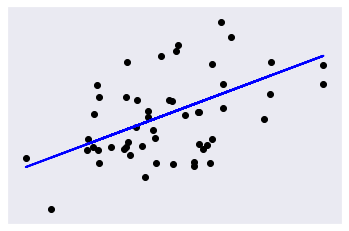

In [11]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training/testing sets
X_train = y_true[:50].reshape(-1, 1)
X_test = y_true[50:].reshape(-1, 1)

# Split the targets into training/testing sets
y_train = y_eq[:50]#.reshape(-1, 1) 
y_test = y_eq[50:]#.reshape(-1, 1)
#y_train

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
#print('Mean squared error: %.2f'
#      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2.0)

plt.xticks(())
plt.yticks(())

plt.show()

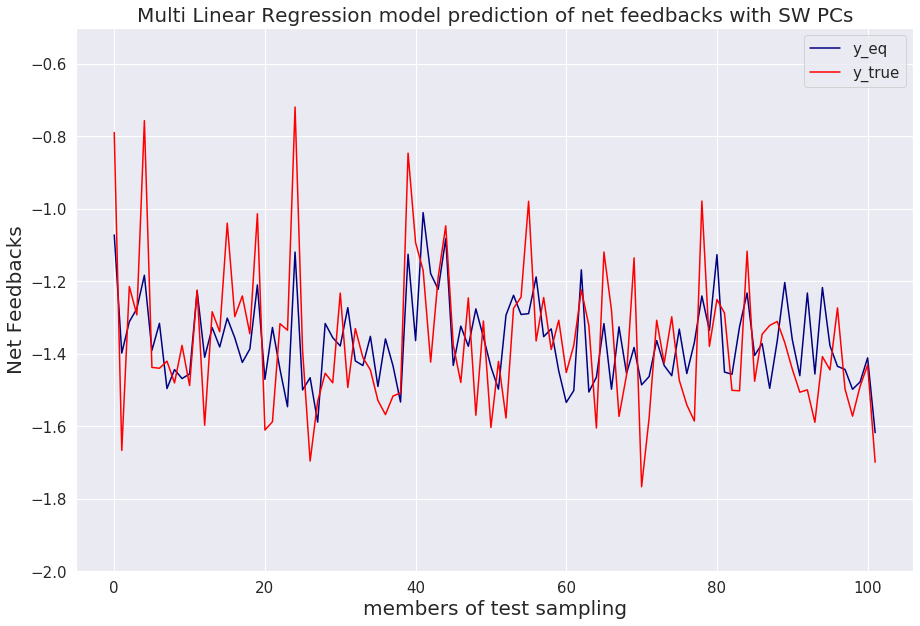

In [12]:
# Plot y_pred and y_test  
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="members_0", y="y_eq", data=DFYeq, color='navy',ax=ax)
ax = sns.lineplot(x="members_0", y="y_true", data=DFYeq, color='red',ax=ax)
plt.title('Multi Linear Regression model prediction of net feedbacks with SW PCs', fontsize=20)
plt.legend(['y_eq','y_true'],fontsize=15)
plt.xlabel('members of test sampling',fontsize=20)
plt.ylabel('Net Feedbacks',fontsize=20)
plt.ylim(-2, -0.5)
ax.tick_params(axis='both', labelsize=15)

## Neural Network 

In [13]:
# Set the X and Y : Y = f(X)
X = PC_df_PPE.values
y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/LHS_paramNames.npy")

In [14]:
# split the dataset
X_train = X[0:80,:]
X_test = X[80:,:]
#X_val = X[40:,:]

y_train = y[0:80]
y_test = y[80:]
#y_val = y[40:]

In [15]:
skill_score=[]

i=1
N=10
while i<N: 
    NN = MLPRegressor(alpha=0.01, hidden_layer_sizes=(5, i))
    NN = NN.fit(X_train,y_train)
    y_pred = NN.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    skill_score.append(score)
    i = ( i + 1 )

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

In [16]:
## BUILD the SKILL dataframe
skill_maxIter = pd.DataFrame()
skill_maxIter['n_layer']=np.arange(1,10,1)
skill_maxIter['RMSE']=skill_score

skill_maxIter

,n_layer,RMSE
0,1,2.464866
1,2,0.249059
2,3,2.039205
3,4,0.180517
4,5,0.166200
5,6,0.691162
6,7,0.447284
7,8,0.395665
8,9,0.169731


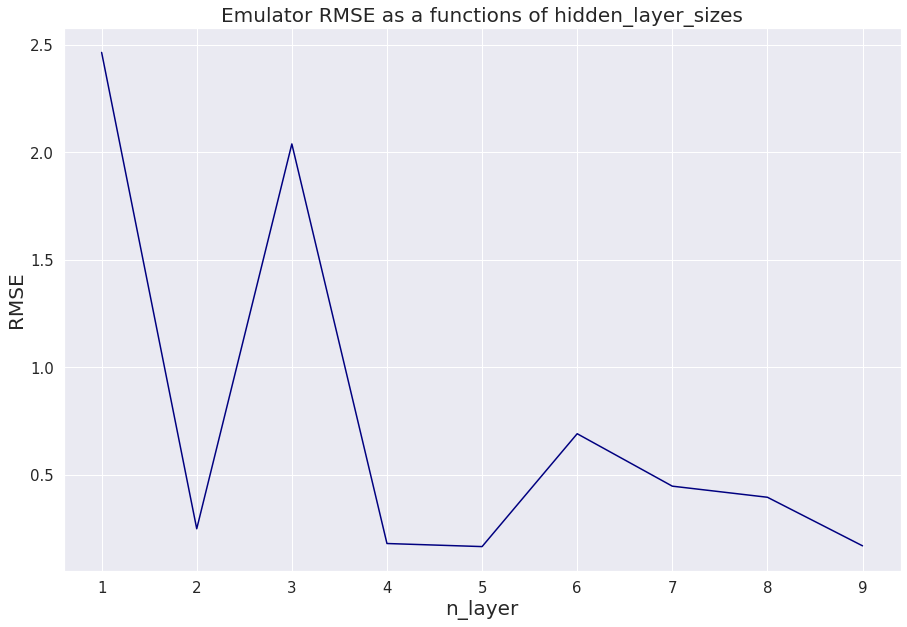

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_layer", y="RMSE", data=skill_maxIter,color='navy',ax=ax)
plt.title('Emulator RMSE as a functions of hidden_layer_sizes', fontsize=20)
plt.xlabel('n_layer',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

#plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_log.png", dpi=None, 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

## Création du modèle

In [52]:
NN = MLPRegressor(hidden_layer_sizes=(5,2))
NN = NN.fit(X_train,y_train)

y_val = NN.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_val))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_val))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_val)))

Mean Absolute Error: 0.2774500881087882
Mean Squared Error: 0.16226635890249794
Root Mean Squared Error: 0.4028229870582089


/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [53]:
DFYeq_NN  = pd.DataFrame()
DFYeq_NN['y_eq'] = y_val
DFYeq_NN['y_true'] = y_test
DFYeq_NN['members'] = range(0,22,1)
DFYeq_NN

,y_eq,y_true,members
0,-2.094217,-1.249944,0
1,-1.178365,-1.287240,1
2,-1.319305,-1.500698,2
3,-1.038456,-1.501852,3
4,-2.453505,-1.116849,4
5,-1.383364,-1.475588,5
6,-1.097721,-1.345804,6
7,-1.329955,-1.321564,7
8,-1.106179,-1.310618,8
9,-1.457415,-1.368696,9


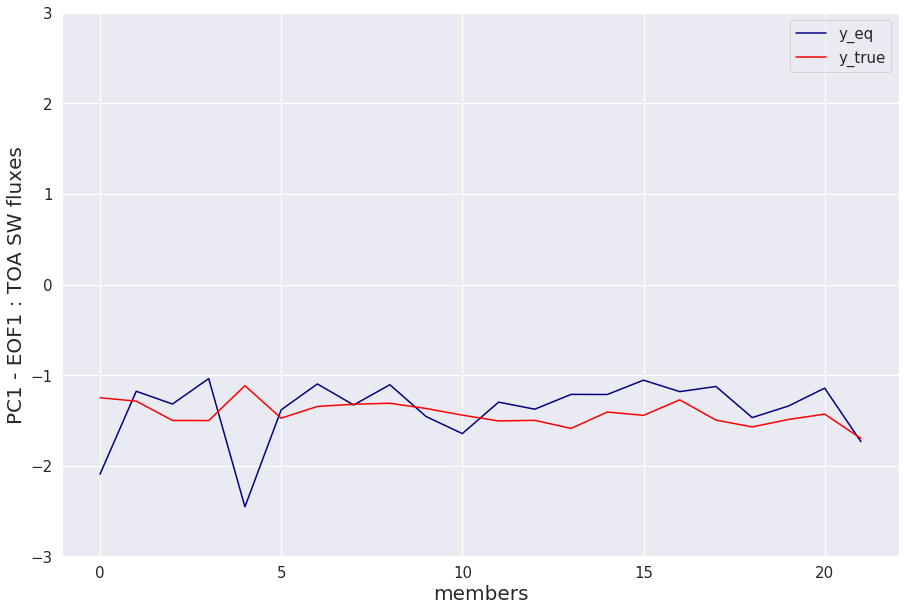

In [54]:
# Plot y_pred and y_test  
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="members", y="y_eq", data=DFYeq_NN,color='navy',ax=ax)
ax = sns.lineplot(x="members", y="y_true", data=DFYeq_NN,color='red',ax=ax)
#plt.title('Emulator RMSE as a functions of max_iter', fontsize=20)
plt.legend(['y_eq','y_true'],fontsize=15)
plt.xlabel('members',fontsize=20)
plt.ylabel('PC1 - EOF1 : TOA SW fluxes',fontsize=20)
plt.ylim(-3, 3)
ax.tick_params(axis='both', labelsize=15)

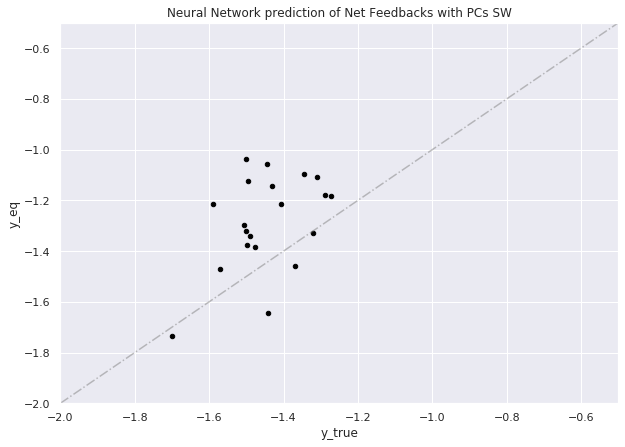

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = plt.gca()
title = 'Neural Network prediction of Net Feedbacks with PCs SW'

diag = pd.DataFrame(range(-2,2,1))
diag['x'] = diag[0]
diag['y'] = diag[0]
diag = diag.drop(columns = 0)
diag.plot(kind='line', x='x', y='y', color='gray', alpha=0.5, legend = False,linestyle='-.', ax = ax)

DFYeq_NN.plot(kind='scatter', x='y_true', y='y_eq', color='black', figsize=(10, 7), 
                     style='.', ax = ax)

plt.xlabel('y_true')
plt.ylabel('y_eq')
plt.title(title)
plt.xlim(-2,-0.5)
plt.ylim(-2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/PPE_NN_NetFdbck_with_SWpc.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()